In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import os 


In [ ]:
np.random.seed(42)
n_samples = 10000


num_employees = np.random.randint(5, 500, n_samples)
annual_revenue = np.random.randint(5000, 1_000_000, n_samples)
avg_employee_salary = np.random.randint(500, 5000, n_samples)
expenses_total = np.random.randint(1000, 500_000, n_samples)
customer_growth_rate = np.random.rand(n_samples)  # 0-1
customer_retention_rate = np.random.rand(n_samples)  # 0-1
digital_spending_ratio = np.random.rand(n_samples)  # 0-1
years_in_operation = np.random.randint(1, 30, n_samples)
profit_to_expense_ratio = np.random.rand(n_samples)  # 0-1

regions = ['Urban', 'Rural']
sectors = ['Tech', 'Finance', 'Healthcare', 'Retail', 'Manufacturing']
tech_levels = ['Low', 'Medium', 'High']
remote_policies = ['None', 'Partial', 'Full']

region = np.random.choice(regions, n_samples)
sector = np.random.choice(sectors, n_samples)
tech_adoption_level = np.random.choice(tech_levels, n_samples)
remote_work_policy = np.random.choice(remote_policies, n_samples)

noise = np.random.normal(0, 0.05, n_samples)  
revenue_growth_rate = (
    0.0005*num_employees + 
    0.3*digital_spending_ratio + 
    0.2*customer_growth_rate + 
    0.1*profit_to_expense_ratio +
    noise
)

revenue_growth_rate = np.clip(revenue_growth_rate, -0.2, 1.0)


df = pd.DataFrame({
    'num_employees': num_employees,
    'annual_revenue': annual_revenue,
    'avg_employee_salary': avg_employee_salary,
    'expenses_total': expenses_total,
    'customer_growth_rate': customer_growth_rate,
    'customer_retention_rate': customer_retention_rate,
    'digital_spending_ratio': digital_spending_ratio,
    'years_in_operation': years_in_operation,
    'profit_to_expense_ratio': profit_to_expense_ratio,
    'region': region,
    'sector': sector,
    'tech_adoption_level': tech_adoption_level,
    'remote_work_policy': remote_work_policy,
    'revenue_growth_rate': revenue_growth_rate
})

df.head()


,num_employees,annual_revenue,avg_employee_salary,expenses_total,customer_growth_rate,customer_retention_rate,digital_spending_ratio,years_in_operation,profit_to_expense_ratio,region,sector,tech_adoption_level,remote_work_policy,revenue_growth_rate
0,107,622397,2435,432476,0.503741,0.142242,0.830644,22,0.642179,Rural,Healthcare,Low,None,0.425124
1,440,155259,1133,404365,0.269505,0.834702,0.680364,17,0.318610,Rural,Tech,Low,Partial,0.486629
2,353,148029,1753,355349,0.650244,0.541434,0.870065,12,0.682133,Urban,Healthcare,Low,Partial,0.694007
3,275,402595,1582,158400,0.335793,0.626770,0.329051,19,0.778228,Urban,Healthcare,Medium,Full,0.396550
4,111,950463,2643,366447,0.367246,0.809206,0.854426,29,0.306624,Urban,Healthcare,Low,None,0.364142


In [3]:
os.makedirs("data/raw", exist_ok=True)
df.to_csv("../data/raw/sme_revenue_growth_synthetic_data.csv", index=False)

In [4]:
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()


,num_employees,annual_revenue,avg_employee_salary,expenses_total,customer_growth_rate,customer_retention_rate,digital_spending_ratio,years_in_operation,profit_to_expense_ratio,revenue_growth_rate,region_Urban,sector_Healthcare,sector_Manufacturing,sector_Retail,sector_Tech,tech_adoption_level_Low,tech_adoption_level_Medium,remote_work_policy_None,remote_work_policy_Partial
0,107,622397,2435,432476,0.503741,0.142242,0.830644,22,0.642179,0.425124,False,True,False,False,False,True,False,True,False
1,440,155259,1133,404365,0.269505,0.834702,0.680364,17,0.318610,0.486629,False,False,False,False,True,True,False,False,True
2,353,148029,1753,355349,0.650244,0.541434,0.870065,12,0.682133,0.694007,True,True,False,False,False,True,False,False,True
3,275,402595,1582,158400,0.335793,0.626770,0.329051,19,0.778228,0.396550,True,True,False,False,False,False,True,False,False
4,111,950463,2643,366447,0.367246,0.809206,0.854426,29,0.306624,0.364142,True,True,False,False,False,True,False,True,False


In [5]:
os.makedirs("data/processed", exist_ok=True)
df_encoded.to_csv("../data/processed/sme_revenue_growth_synthetic_processed.csv", index=False)

In [6]:
X = df_encoded.drop(columns=['revenue_growth_rate'])
y = df_encoded['revenue_growth_rate']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=31,
    random_state=42
)

lgb_model.fit(X_train_scaled, y_train)
y_pred = lgb_model.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2091
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 18
[LightGBM] [Info] Start training from score 0.428223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

c:\projects\Inua360-The-Kenyan-SME-AI-Agent-1\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


                       Feature  Importance
0                num_employees        1938
8      profit_to_expense_ratio        1771
6       digital_spending_ratio        1751
4         customer_growth_rate        1738
2          avg_employee_salary        1525
1               annual_revenue        1509
5      customer_retention_rate        1505
3               expenses_total        1369
7           years_in_operation         876
9                 region_Urban         190
14     tech_adoption_level_Low         156
16     remote_work_policy_None         132
17  remote_work_policy_Partial         106
12               sector_Retail         105
15  tech_adoption_level_Medium          90
13                 sector_Tech          78
10           sector_Healthcare          76
11        sector_Manufacturing          66


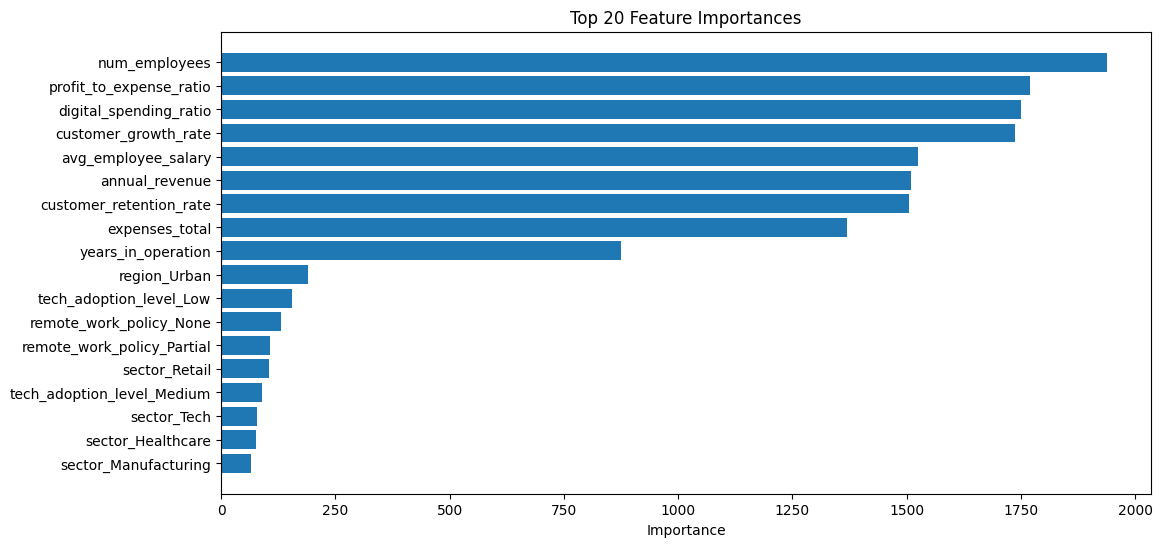

In [ ]:
importances = lgb_model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head(20))


plt.figure(figsize=(12,6))
plt.barh(importance_df['Feature'][:20][::-1], importance_df['Importance'][:20][::-1])
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.show()


In [9]:
df.columns.tolist()

['num_employees',
 'annual_revenue',
 'avg_employee_salary',
 'expenses_total',
 'customer_growth_rate',
 'customer_retention_rate',
 'digital_spending_ratio',
 'years_in_operation',
 'profit_to_expense_ratio',
 'region',
 'sector',
 'tech_adoption_level',
 'remote_work_policy',
 'revenue_growth_rate']